In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
from rdkit.Chem import TemplateAlign

IPythonConsole.use_SVG=False
# IPythonConsole.use_SVG=True  ## comment out this line for GitHub


## Two related macrocycles

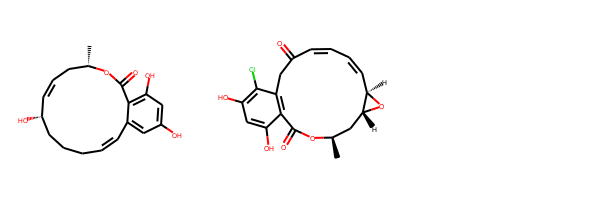

In [2]:
dhz_smiles = 'C[C@H]1C/C=C/[C@H](CCC/C=C/C2=CC(=CC(=C2C(=O)O1)O)O)O'
dhz = Chem.MolFromSmiles(dhz_smiles)  # from smiles

radicicol_smiles = 'C[C@@H]1C[C@@H]2[C@H](O2)/C=C\C=C\C(=O)Cc3c(c(cc(c3Cl)O)O)C(=O)O1'
radicicol = Chem.MolFromSmiles(radicicol_smiles)

my_molecules = [dhz, radicicol]

Draw.MolsToGridImage(my_molecules)

The default depiction of the 14-membered ring is very round, an idiosyncracy of several (not just rdkit) chemoinformatic packages that [has been noted before](https://www.slideshare.net/NextMoveSoftware/rdkit-ugm-2016-higher-quality-chemical-depictions) [see slide 31 in the linked deck].

In this notebook I want to compare ways of forcing these depictions to be less round.

## Loading sdfs from PubChem

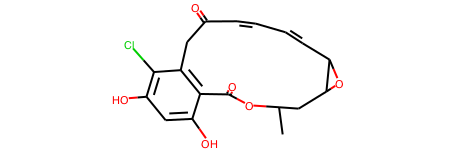

In [3]:
suppl = Chem.SDMolSupplier('Structure3D_CID_5359013.sdf')  # from SDF via pubchem for 3D conformation
radicicol_2 = [mol for mol in suppl][0]
Chem.SanitizeMol(radicicol_2)
radicicol_2

As a first try, I manually downloaded the Pubchem 3D conformer SDF file for one of the molecules.  Since the SDF file specifies a 3D conformation, the rdkit-generated 2D depiction tries to use the 3D information to generate a different 2D depiction.  

To my eye, this is a small but real improvement over the prior version, but is not very scalable or general.  The resulting depiction is still imperfect (e.g. the ester/lactide moiety looks pretty funky, etc.)

## Align to a non-macrocyclic common substructure

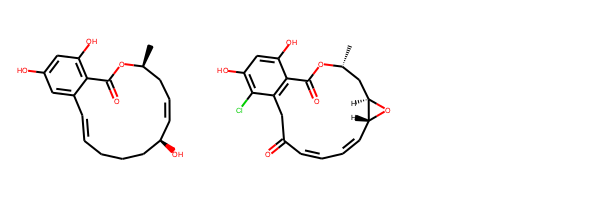

In [4]:
aligner = Chem.MolFromSmarts('[*r14][cR2]2[cR1][cR1](-[#8])[cR1][cR1](-[#8])[cR2]2[#6r14](=[#8])[#8r14][#6r14]')
Chem.GetSSSR(aligner)
AllChem.Compute2DCoords(aligner)

for mol in my_molecules:
    AllChem.GenerateDepictionMatching2DStructure(mol, 
                                                 aligner,
                                                 acceptFailure = True)

highlight_lists = [mol.GetSubstructMatch(aligner) for mol in my_molecules]
Draw.MolsToGridImage(my_molecules,
                     # highlightAtomLists = highlight_lists  ## uncomment this line to show the substructure match
                    )

A second strategy is to align macrocycles to a non-cyclic substructure.  Since the depiction for the non-cyclic substructure will generally not be "rounded", this forces *parts* of the macrocycles to be depicted in a more regular fashion.

The results above show an improvement for the lactide part of the ring, but some rounding is still evident.  To my eye, these are probably the best depictions of these molecules in the notebook.

However, a caveat of this approach is that by using a bigger and bigger substructure, more of the macrocyclic ring is normalized gets, but at some point, the rest of the ring gets worse instead of better.

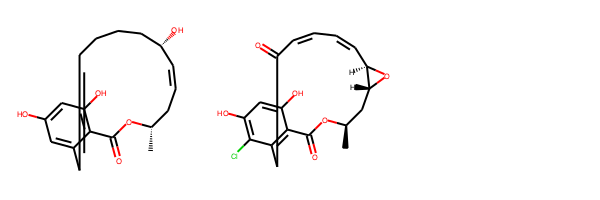

In [5]:
aligner_bigger = Chem.MolFromSmarts('[*r14][cR2]2[cR1][cR1](-[#8])[cR1][cR1](-[#8])[cR2]2[#6r14](=[#8])[#8r14]@[#6r14]@[#6r14]')
Chem.GetSSSR(aligner_bigger)
AllChem.Compute2DCoords(aligner_bigger)

for mol in my_molecules:
    AllChem.GenerateDepictionMatching2DStructure(mol, 
                                                 aligner_bigger,
                                                 acceptFailure = True)

highlight_lists = [mol.GetSubstructMatch(aligner_bigger) for mol in my_molecules]
Draw.MolsToGridImage(my_molecules,
                     # highlightAtomLists = highlight_lists  ## uncomment this line to show the substructure match
                    )

# Aligning to a conformer of cyclotetradecane

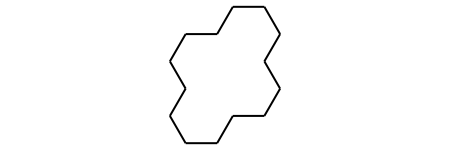

In [6]:
suppl = Chem.SDMolSupplier('Structure2D_CID_67524.sdf')  # from SDF via pubchem for 3D conformation
ring_templ = [mol for mol in suppl][0]
Chem.GetSSSR(ring_templ)

ring_templ

A third strategy is to use `AlignMolToTemplate2D()` and to force parts of the molecule to have a desired depiction.  Here, I download a 2D sdf file from Pubchem for cyclotetradecane and try to use it as a template for the macrocyclic part of my target molecules.

In [7]:
# identify atoms in the 14-membered ring

ring_info_list = [mol.GetRingInfo() for mol in my_molecules]
mol_atoms_in_rings = [ring_info.AtomRings() for ring_info in ring_info_list]

size_14_rings = []
for rings in mol_atoms_in_rings:
    for ring in rings:
        if len(ring) == 14:
            size_14_rings.append(ring)
            
print(size_14_rings)

[(1, 19, 17, 16, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2), (1, 24, 22, 14, 13, 12, 10, 9, 8, 7, 6, 4, 3, 2)]


**ASIDE:**

I had to use `RingInfo` to get the macrocyclic ring atoms because SMARTS `[*r14]` queries will _not_ hit the ring atoms in the oxirane ring or in the benzene ring. `[*r14]` will only hit atoms for which the _smallest_ ring they are a part of is a 14-cycle.  Is there a better SMARTS query to use here?

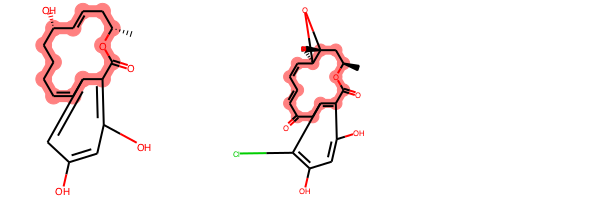

In [8]:
for idx, mol in enumerate(my_molecules):
    TemplateAlign.AlignMolToTemplate2D(mol, 
                                       ring_templ, 
                                       match=size_14_rings[idx],
                                       clearConfs=True)

Draw.MolsToGridImage(my_molecules,
                    highlightAtomLists = size_14_rings
                    )

The macrocycles look great!  However, the rest of the molecule, in particular the benzene ring, is a bit stretched.